# OpenABM-Covid19 - Recursive Testing

This examples compares contact tracing with and without recursive testing.

In [62]:
import example_utils as utils
import pandas as pd
from math import exp

n_total = 1e5
frac_lockdown = 0.02
days_lockdown = 60
frac_app_users = 0.70
social_distance_factor = 0.8


Run the model until `frac_lockdown` of the population are infected.

In [63]:
params = utils.get_baseline_parameters()
params.set_param( "infectious_rate", 4.8 )
params.set_param( "n_total", n_total )
params.set_param( "test_insensitive_period", 3 )
params.set_param( "test_sensitivity", 0.8 )
params.set_param( "test_specificity", 0.99)
params.set_param( "test_release_on_negative", 1)

app_users_param = [ "app_users_fraction_0_9", "app_users_fraction_10_19",  "app_users_fraction_20_29",  
        "app_users_fraction_30_39",  "app_users_fraction_40_49", "app_users_fraction_50_59",    
        "app_users_fraction_60_69",  "app_users_fraction_70_79", "app_users_fraction_80" ]

for age in range(len(app_users_param)):
    params.set_param( app_users_param[age], params.get_param(app_users_param[age])*frac_app_users)

sim = utils.get_simulation( params )
sim.env.model.one_time_step()
sim.steps(1)
time_lockdown = 0
while sim.results["total_infected"][ -1] < frac_lockdown * n_total:
    time_lockdown = time_lockdown + 1
    sim.steps(1)

Now turn on a lockdown and continue for `days_lockdown` days.

In [64]:
sim.env.model.update_running_params("self_quarantine_fraction", 0.5 )
sim.env.model.update_running_params("quarantine_household_on_symptoms", 1 )
sim.env.model.update_running_params("quarantine_household_on_positive", 1 )
sim.env.model.update_running_params("lockdown_house_interaction_multiplier", 1.5)
sim.env.model.update_running_params("lockdown_random_network_multiplier", 0.21)
sim.env.model.update_running_params("lockdown_occupation_multiplier_primary_network", 0.21)
sim.env.model.update_running_params("lockdown_occupation_multiplier_secondary_network", 0.21)
sim.env.model.update_running_params("lockdown_occupation_multiplier_working_network", 0.21)
sim.env.model.update_running_params("lockdown_occupation_multiplier_retired_network", 0.21)
sim.env.model.update_running_params("lockdown_occupation_multiplier_elderly_network", 0.21)
sim.env.model.update_running_params("lockdown_on", 1)
sim.steps( days_lockdown )

Now turn off the lockdown and turn on digitial contract tracing, with the following options.
1. 80% of people self-quarantine along with their household when they develop symptoms.
2. Tracing happens on a positive test
3. The households members of those traced also quarantine

We then run the simimulation for another 100 days.

In [65]:
# lockdown off
#sim.env.model.update_running_params("lockdown_on", 0)
sim.env.model.update_running_params( "lockdown_house_interaction_multiplier", 1 )
sim.env.model.update_running_params( "lockdown_random_network_multiplier", social_distance_factor )
sim.env.model.update_running_params( "lockdown_occupation_multiplier_primary_network", social_distance_factor )
sim.env.model.update_running_params( "lockdown_occupation_multiplier_secondary_network", social_distance_factor )
sim.env.model.update_running_params( "lockdown_occupation_multiplier_working_network", social_distance_factor )
sim.env.model.update_running_params( "lockdown_occupation_multiplier_retired_network", social_distance_factor )
sim.env.model.update_running_params( "lockdown_occupation_multiplier_elderly_network", social_distance_factor )

# 80% self-quarantine along with their households
sim.env.model.update_running_params("self_quarantine_fraction", 0.8 )
sim.env.model.update_running_params("quarantine_household_on_symptoms", 1 )
  
# turn on the app and quarantine those people who have been traced along with their households
sim.env.model.update_running_params("app_turned_on", 1 )
sim.env.model.update_running_params("quarantine_on_traced", 1 )
sim.env.model.update_running_params("trace_on_positive", 1 )
sim.env.model.update_running_params("trace_on_symptoms", 0 )
sim.env.model.update_running_params("test_on_symptoms", 1 )
sim.env.model.update_running_params("test_on_traced", 1 )
sim.env.model.update_running_params("test_result_wait", 1 )
sim.env.model.update_running_params("test_order_wait", 1 )
sim.env.model.update_running_params("test_release_on_negative", 1 )

sim.env.model.update_running_params("quarantine_household_on_traced_positive", 1 )

# add risk scoring
#risk_sd = 3.5
#for day in range( 10 ):
#    for age_inf in range( 9 ):
#        for age_sus in range( 9 ):
#            sim.env.model.set_risk_score( day, age_inf, age_sus, exp( 0.5 * ( 1 - day*day / risk_sd/risk_sd ) ) )
     
# apply social distancing measures
#sim.env.model.update_running_params("relative_transmission_occupation", social_distance_factor )
#sim.env.model.update_running_params("relative_transmission_random", social_distance_factor )

# step forwrard another 100 days
weekly_prev = 1e-3
time = 0
while time < 100:
    time = time+1
    sim.steps(1)
    if pd.DataFrame( sim.results )["total_infected"].diff(7).iloc[-1] < n_total * weekly_prev:
        sim.env.model.update_running_params("test_release_on_negative", 1 )
    else :
        sim.env.model.update_running_params("test_release_on_negative", 1 )


Finally plot the result.

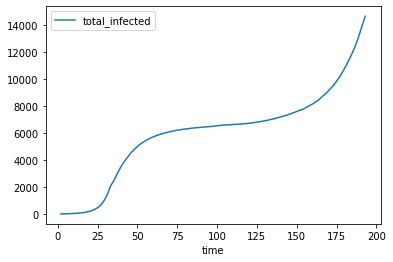

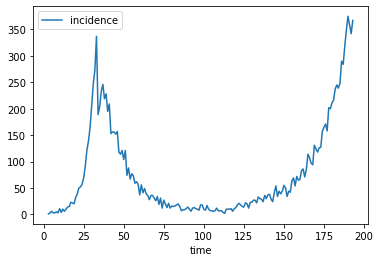

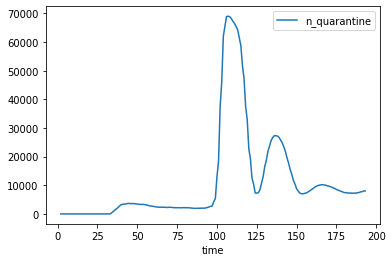

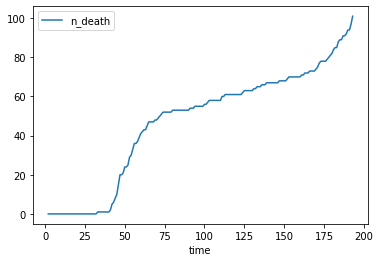

In [66]:
timeseries = pd.DataFrame( sim.results )
timeseries["incidence"] = timeseries["total_infected"].diff()
timeseries.plot( x = "time", y = "total_infected" )
timeseries.plot( x = "time", y = "incidence" )
timeseries.plot( x = "time", y = "n_quarantine" )
timeseries.plot( x = "time", y = "n_death" )

In [67]:
import numpy as np
np.exp((max(np.log(timeseries["incidence"][ 115:145]))-min(np.log(timeseries["incidence"][ 115:145])))/30*6)

1.5518455739153598

In [68]:
del(sim)